final 1

In [1]:
print("TR for more currency")

TR for more currency


In [3]:
import os
print(len(os.listdir("/app/PaddleOCR/train_data/original_format/train_data4")))

24045


In [4]:
print(len(os.listdir("/app/PaddleOCR/train_data/original_format/superscripts_currency_first_train_all_May_7th_2025/train_data")))

1532695


In [ ]:
# !pip install matplotlib

tyring with smooth font function

In [5]:
import numpy as np
from scipy.stats import truncnorm

def sample_truncnorm_with_tail_and_baseline(min_val, max_val, mean, std,
                                             tail_smooth='both',
                                             suppression_strength=3.0,
                                             baseline_weight=0.2,
                                             size=1000, grid_points=1000, seed=None,
                                             return_pdf=False):

    if seed is not None:
        np.random.seed(seed)

    if tail_smooth not in ['left', 'right', 'both', None]:
        raise ValueError("tail_smooth must be 'left', 'right', 'both', or None")

    # Step 1: Grid over support
    x = np.linspace(min_val, max_val, grid_points)

    # Step 2: Truncated normal PDF
    a = (min_val - mean) / std
    b = (max_val - mean) / std
    gauss_pdf = truncnorm.pdf(x, a=a, b=b, loc=mean, scale=std)

    # Step 3: Exponential tail suppression
    if tail_smooth in ['left', 'both']:
        mask_left = x < mean
        decay_left = np.exp(-suppression_strength * (mean - x[mask_left]))
        gauss_pdf[mask_left] *= decay_left

    if tail_smooth in ['right', 'both']:
        mask_right = x > mean
        decay_right = np.exp(-suppression_strength * (x[mask_right] - mean))
        gauss_pdf[mask_right] *= decay_right

    # Step 4: Uniform baseline PDF
    baseline_pdf = np.ones_like(x) / (max_val - min_val)

    # Step 5: Mix PDFs
    mixed_pdf = (1 - baseline_weight) * gauss_pdf + baseline_weight * baseline_pdf

    # Step 6: Normalize
    mixed_pdf /= mixed_pdf.sum()

    # Step 7: Sample
    samples = np.random.choice(x, size=size, p=mixed_pdf)

    if return_pdf:
        return samples, x, mixed_pdf
    return samples
###########################################################################
import matplotlib.pyplot as plt


def sample_font_size(min_v=20, max_v=64, mean=27):
    digits = list(range(min_v, max_v+1))
    n = len(digits)
    samples = sample_truncnorm_with_tail_and_baseline(
        min_val=0,
        max_val=n - 1,
        mean=mean-min_v+1,  # peak at '1'
        std=2.0,
        tail_smooth='both',
        baseline_weight=0.3,
        suppression_strength=0.2,
        size=1,
        return_pdf = False
    )
    idx = int(round(samples[0].clip(0, n - 1)))
    return digits[idx]

def plot_distribution(sampler_func, label, num_samples=10000):
    samples = [sampler_func() for _ in range(num_samples)]
    freq = {c: samples.count(c)/num_samples for c in set(samples)}
    
    sorted_freq = dict(sorted(freq.items()))
    
    plt.figure(figsize=(10, 4))
    bars = plt.bar(sorted_freq.keys(), sorted_freq.values())
    plt.title(f"{label} Frequency Distribution")
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', axis='y', alpha=0.5)

    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                 f'{height*100:.1f}%', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()
    
def sample_by_precentage(percentage_True):
    # return percentage that is true
    # 10 percentage that is True
    threshold = 100 - percentage_True
    if np.random.randint(1, 100 + 1) > threshold:
        return True
    else:
        return False

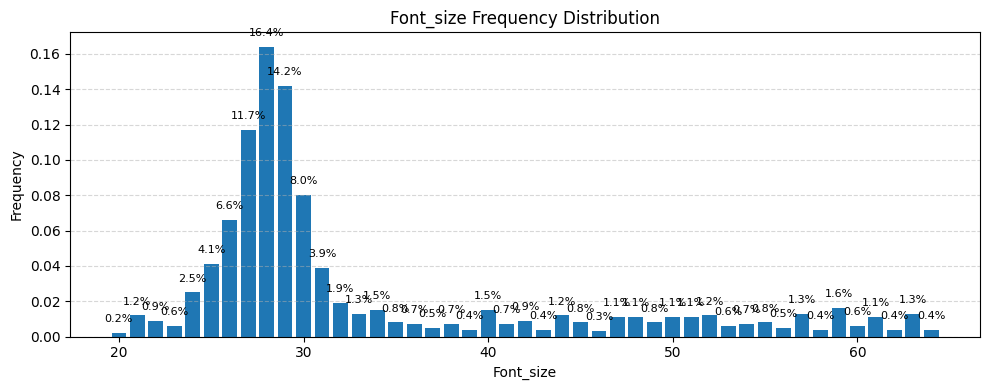

In [6]:
plot_distribution(sample_font_size, "Font_size", num_samples=1000)

trying to generate only samples from fonts  which are not well repsented

In [12]:
#final  2
import os
import random
import re
import math
from collections import defaultdict

from trdg.generators import GeneratorFromStrings
import matplotlib.pyplot as plt
import numpy as np

currency_groups = {
    "latin": [
        "pound", 
        "usdollar", 
        "hongkongdollar",
        "cent"
    ],
    "devanagari": ["rupee"], 
    
    "symbol": ["bitcoin"], 
    "default": []
}


myfonts_dir = './myfonts/'
fonts_latin = [
    # './myfonts/ARIAL.ttf',
    # './myfonts/times_new_roman.ttf', not generating euro,koruna
    './myfonts/Roboto-Regular.ttf', #not generating peso
    './myfonts/Calibri Regular.ttf',
    # './myfonts/Garamond Regular.ttf',
    # './myfonts/georgia.ttf',
    # './myfonts/Helvetica.ttf',
    # './myfonts/LibreBaskerville-Regular.ttf',
    './myfonts/couriernew.ttf',
    './myfonts/Merriweather-Regular.ttf',
    './myfonts/Oswald-Regular.ttf',
    './myfonts/impact.ttf',
    # './myfonts/OpenSans-Regular.ttf', #not generating lira,peso
    # './myfonts/DejaVuSans.ttf',
    # './myfonts/LiberationSans-Regular.ttf', #not generating lira
    # './myfonts/IBMPlexSans-Regular.ttf',
]
fonts_latin_extended_symbol = [
    './myfonts/ARIAL.ttf',
    './myfonts/DejaVuSans.ttf',
    './myfonts/NotoSans-Regular.ttf',
]


fonts_cyrillic = [
    './myfonts/DejaVuSans.ttf',
    './myfonts/NotoSans-Regular.ttf',
    './myfonts/ARIAL.ttf',
    
]


fonts_cjk = [
    './myfonts/DejaVuSans.ttf',
    './myfonts/NotoSansJP-Regular.ttf',
    './myfonts/ARIAL.ttf',
    './myfonts/NotoSansKR-Regular.ttf',
]


fonts_devanagari = [
    './myfonts/NotoSansDevanagari-Regular.ttf',
    './myfonts/HindSiliguri-Regular.ttf',
    './myfonts/DejaVuSans.ttf',
    './myfonts/IBMPlexSans-Regular.ttf',
    './myfonts/ARIAL.ttf',
    './myfonts/Oswald-Regular.ttf',
]


fonts_bengali = [
    './myfonts/NotoSansBengali-Regular.ttf',
    './myfonts/HindSiliguri-Regular.ttf',
]

fonts_thai = [
    './myfonts/NotoSansThai-Regular.ttf',
    './myfonts/NotoSerifThai-Regular.ttf',
    './myfonts/IBMPlexSans-Regular.ttf',
]

fonts_hebrew = [
    './myfonts/NotoSansHebrew-Regular.ttf',
    './myfonts/DejaVuSans.ttf', 
    './myfonts/ARIAL.ttf', 
]


fonts_arabic = [
    './myfonts/NotoSansArabic-Regular.ttf',
    './myfonts/Amiri-Regular.ttf',
    './myfonts/ScheherazadeNew-Regular.ttf',
    './myfonts/IBMPlexSansArabic-Regular.ttf',
]

fonts_symbol = [
    # './myfonts/NotoSansSymbols2-Regular.ttf',
    # './myfonts/DejaVuSans.ttf',
    './myfonts/IBMPlexSans-Regular.ttf',
    './myfonts/ARIAL.ttf',

]

# Fallback fonts
fonts_default = [
    './myfonts/ARIAL.ttf',
    './myfonts/IBMPlexSans-Regular.ttf'
]


group_font_map = {
    "latin": fonts_latin, "latin_extended_symbol": fonts_latin_extended_symbol,
    "cyrillic": fonts_cyrillic, "cjk": fonts_cjk, "devanagari": fonts_devanagari,
    "bengali": fonts_bengali, "thai": fonts_thai, "hebrew": fonts_hebrew,
    "arabic": fonts_arabic, "symbol": fonts_symbol, "default": fonts_default
}

currency_to_group = {}
all_defined_currencies = set()
for group, currencies in currency_groups.items():
    if not group_font_map.get(group): continue
    for currency_name in currencies:
        if currency_name in currency_to_group:
            print(f"Warning: Currency '{currency_name}' assigned multiple times. Using group '{group}'.")
        currency_to_group[currency_name] = group
        all_defined_currencies.add(currency_name)

currency_definitions = [
    {'symbol': '£', 'name': 'pound'},
    {'symbol': '₹', 'name': 'rupee'},
    {'symbol': 'HK$', 'name': 'hongkongdollar'},
    {'symbol': '¢', 'name': 'cent'},
    {'symbol': 'US$', 'name': 'usdollar'}
]
defined_currency_names = {d['name'] for d in currency_definitions}
unassigned_currencies = defined_currency_names - all_defined_currencies
if unassigned_currencies:
    print(f"ERROR: Following currencies defined but not assigned to group with fonts: {unassigned_currencies}.")


main_output_dir = "./new_output_TR_more_currencies_test" 
image_subdir = "images"
label_subdir = "labels"
stats_subdir = "stats"
label_file_name = "labels.txt"
background_image_dir = "./img_dir"
num_images_per_symbol_definition = 100 # for test    200 for training
target_skew_percentage = 0.05 # 5% skewed images

# generate amount
def generate_formatted_amount_equal_prob(symbol, 
                                         range_counts, 
                                         min_max_tracker, 
                                         base_format_counts,
                                         final_format_count,
                                         just_symbol=False):
    amount = 0
    range_key = 'unknown' 
    rand_gen_choice = random.random()
    if just_symbol:
        return symbol
    ranges = [
    ('Specific Max Float', lambda: 9999999999.99, 0.01),   # 1%
    ('0-9', lambda: random.randint(0, 9), 0.05),            # 5%
    ('0.01 - <10 (float)', lambda: random.uniform(0.01, 10), 0.09),  # 5%
    ('10 - <100M (int)', lambda: random.randint(10, 99_999_999), 0.06),  # 5%
    ('10 - <100M (float)', lambda: random.uniform(10, 99_999_999), 0.27),  # 15%
    ('100M - 200M (int)', lambda: random.randint(100_000_000, 200_000_000), 0.06),  # 15%
    ('100M - 200M (float)', lambda: random.uniform(100_000_000, 200_000_000), 0.16),  # 24%
    ('>200M - <10B (int)', lambda: random.randint(200_000_001, 9_999_999_998), 0.05), # 10%
    ('>200M - <10B (float)', lambda: random.uniform(200_000_00.99, 9_999_999_999.98), 0.25),  # 20%
    ]

    range_key, value_fn = random.choices(
        [(label, fn) for label, fn, _ in ranges],
        weights=[w for _, _, w in ranges],
        k=1
    )[0]

    amount = value_fn()

    range_counts[range_key] += 1

    min_max_tracker['min'] = min(min_max_tracker['min'], amount)
    min_max_tracker['max'] = max(min_max_tracker['max'], amount)

    # check whole number
    is_whole_number = isinstance(amount, int) or (isinstance(amount, float) and math.isclose(math.modf(amount)[0], 0.0, abs_tol=1e-7))
    
    # if is_whole_number and isinstance(amount, float):
    #     amount = round(amount) # Convert floats like 123.0 to int 123 for formatting

    # Define the four base formatting styles
    base_format_options = {
        'Standard (,)': f"{int(amount):,}" if is_whole_number else f"{amount:,.2f}",
        # 'No Separators': str(int(amount)) if is_whole_number else str(round(amount * 100)), 
        'Comma Only': f"{int(round(amount)):,}", 
        # 'Dot Only': f"{amount:.0f}" if is_whole_number else f"{amount:.2f}" 
    }
    base_format_names = list(base_format_options.keys())

    # Select one base format
    # selected_base_format_name = random.choice(base_format_names)
    
    if "float" in range_key.lower():
        selected_base_format_name = "Standard (,)"
    else:
        selected_base_format_name = "Comma Only"
        
    base_format_counts[selected_base_format_name] += 1
    num_str = base_format_options[selected_base_format_name]

    # Build final strings based on the chosen base format
    final_formatted_strings = [
        f"-{symbol}{num_str}",
        f"{symbol}-{num_str}",
        f"{symbol}({num_str})",
        f"{symbol}{num_str}",
        f"{symbol}",
    ]
    format_names = [
    "negative_symbol_number",
    "symbol_negative__number",
    "symbol_parentheses_number",
    "symbol_number",
    "symbol_only",
    ]
    weights = [ 0.31666666666666666, 0.04, 0.30666666666666666, 0.31666666666666666,0.02]
    total_weight = sum(weights)
    normalized_weights = [w/total_weight for w in weights]
    
    formatted_dict = {
    format_names[i]: final_formatted_strings[i].format(symbol=symbol, num_str=num_str)
    for i in range(len(final_formatted_strings))
    }
    random_format_name, random_format_value = random.choices(list(formatted_dict.items()),
                                                            weights=normalized_weights,k=1)[0]
    final_format_count[random_format_name] += 1
    # print(f"The dictionary of formatted strings: {formatted_dict}")
    # print(f"A randomly chosen format name: {random_format_name}")
    # print(f"The corresponding value: {random_format_value}")
    return random_format_value
    # return random.choice(final_formatted_strings)

############################################################################

def generate_custom_color_2(exclude_light_colors=False):
    color_categories = {        
        'black':      {'r': (0, 30),   'g': (0, 30),   'b': (0, 30)},
        'dark_blue':  {'r': (0, 30),   'g': (0, 30),   'b': (80, 150)},
        'dark_gray': {'r': (50, 100),   'g': (50, 100),   'b': (50, 100)},
        'dark_green': {'r': (0, 30),   'g': (60, 100),   'b': (0, 30)},
        'red': {'r': (200, 255),   'g': (0, 40),   'b': (0, 40)},
        'blue': {'r': (0, 100),   'g': (0, 100),   'b': (180, 255)},
        'purple': {'r': (100, 200),   'g': (0, 120),   'b': (120, 225)},
        'yellow': {'r': (200, 255),   'g': (180, 255),   'b': (0, 100)},
        'pink':     {'r': (200, 255),'g': (100, 200),'b': (150, 200)},
        'orange':   {'r': (200, 255),'g': (100, 165),'b': (0, 50)},
        'white':    {'r': (220, 255),'g': (220, 255),'b': (220, 255)}
    }

    color_weights = {
        'black': 0.5,
        'dark_blue': 0.30,
        'dark_gray': 0.10,
        'dark_green': 0.05,
        'red': 0.03,
        'blue': 0.01,
        'purple': 0.005,
        'yellow': 0.003,
        'pink': 0.001,
        'orange': 0.0005,
        'white': 0.0005
    }

    if exclude_light_colors:
        filtered_categories = {k: v for k, v in color_categories.items() if k not in ['white', 'pink']}
    else:
        filtered_categories = color_categories

    categories = list(filtered_categories.keys())
    weights = [color_weights[cat] for cat in categories]

    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]

    selected_category = random.choices(categories, weights=normalized_weights, k=1)[0]
    ranges = filtered_categories[selected_category]
    r = random.randint(*ranges['r'])
    g = random.randint(*ranges['g'])
    b = random.randint(*ranges['b'])

    return selected_category, '#{:02x}{:02x}{:02x}'.format(r, g, b)


##################################
def save_stats_text(filepath, data_dict, header):
    try:
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(f"{header}\n{'=' * len(header)}\n")
            if isinstance(data_dict, dict):
                sorted_items = sorted(data_dict.items(), key=lambda item: item[1] if isinstance(item[1], (int, float)) else 0, reverse=True)
                for k, v in sorted_items:
                     f.write(f"{str(k)}: {v}\n")
            else: 
                 f.write(str(data_dict)) 
        print(f"Text stats saved: {os.path.basename(filepath)}")
    except Exception as e: print(f"Error saving text stats '{os.path.basename(filepath)}': {e}")


def save_stats_plot(filepath, data_dict, title, xlabel, ylabel):
    if plt is None or not data_dict: return
    try:
        keys = [str(k) for k in data_dict.keys()]
        values = list(data_dict.values())
        try:
            numeric_keys = [int(k) for k in keys]
            sorted_indices = np.argsort(numeric_keys)
            keys = [keys[i] for i in sorted_indices]
            values = [values[i] for i in sorted_indices]
        except ValueError: 
            
            sorted_indices = np.argsort(keys)
            keys = [keys[i] for i in sorted_indices]
            values = [values[i] for i in sorted_indices]


        plt.figure(figsize=(max(10, len(keys) * 0.5), 6))
        bars = plt.bar(keys, values)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        for bar in bars:
            yval = bar.get_height()
            if yval > 0:
                plt.text(
                    bar.get_x() + bar.get_width()/2.0, yval, 
                    int(yval), 
                    va='bottom', 
                    ha='center', 
                    fontsize=8
                )
        plt.savefig(filepath); plt.close(); print(f"   - Plot saved: {os.path.basename(filepath)}")
    except Exception as e: print(f"   - Error generating plot '{title}': {e}")


# generate images and labels 
def generate_currency_images_and_labels_fv2():
    global num_images_per_symbol_definition
    output_dir = os.path.join(main_output_dir, image_subdir)
    labels_dir = os.path.join(main_output_dir, label_subdir)
    stats_dir = os.path.join(main_output_dir, stats_subdir)
    label_file_path = os.path.join(labels_dir, label_file_name)

    # Initialize Statistics dicts 
    currency_counts = defaultdict(int)
    color_counts = defaultdict(int)
    final_format_counts = defaultdict(int)
    
    range_keys = [
        '0-9', '0.01 - <10 (float)', '10 - <100M (int)', '10 - <100M (float)',
        '100M - 200M (int)', '100M - 200M (float)', '>200M - <10B (int)',
        '>200M - <10B (float)', 'Specific Max Float', 'Unknown'
    ]
    range_counts = defaultdict(int, {key: 0 for key in range_keys})
    font_size_actual_counts = defaultdict(int)
    min_max_tracker = {'min': float('inf'), 'max': float('-inf')}
    base_format_counts = defaultdict(int)

    all_strings_data = []
    total_skipped = 0
    # populate all_strings_data
    cnt = 0
    for definition in currency_definitions:
        # if cnt == 1:
        #     break
        # if "dollar" in definition['name']:
        #     num_images_per_symbol_definition = 50
        # else:
        #     num_images_per_symbol_definition = 200
        
        cnt += 1
        currency_name = definition['name']
        symbol_to_display = definition['symbol']
        target_group = currency_to_group.get(currency_name)
        count_of_currency = 0
        if not target_group:
            print(f"Skipping {currency_name}: No group assigned.")
            total_skipped += num_images_per_symbol_definition
            continue
        applicable_fonts = group_font_map.get(target_group)
        if not applicable_fonts:
            print(f"Skipping {currency_name}: No fonts found for group '{target_group}'.")
            total_skipped += num_images_per_symbol_definition
            continue

        for i in range(num_images_per_symbol_definition):
            selected_size = sample_font_size()
            
            font_size_actual_counts[selected_size] += 1
            if count_of_currency < 1:
                #genrate one image as symbol only
                amount_string = generate_formatted_amount_equal_prob(
                    symbol_to_display,
                    range_counts,
                    min_max_tracker,
                    base_format_counts,
                    final_format_counts,
                    just_symbol=True
                )
                count_of_currency += 1
            else:
                amount_string = generate_formatted_amount_equal_prob(
                    symbol_to_display,
                    range_counts,
                    min_max_tracker,
                    base_format_counts,
                    final_format_counts,
                    just_symbol=False
                )    
            

            selected_font_path = applicable_fonts[i % len(applicable_fonts)]
            #dont select courier font if dollar is currency
            if any(k in currency_name for k in ["cent", "pound"]) and "couriernew" in selected_font_path.lower():
                selected_font_path = applicable_fonts[(i+1) % len(applicable_fonts)]
            
            all_strings_data.append(
                {
                    'text': amount_string,
                    'name': currency_name,
                    'font': selected_font_path,
                    'size': selected_size
                }
            )

    if total_skipped > 0: print(f"\nNote: Skipped {total_skipped} instances due to font/group issues.")

    # Determine images to skew 
    total_items = len(all_strings_data)
    num_skewed = 0 
    skew_indices = set() 
    if total_items > 0:
        num_skewed = int(round(total_items * target_skew_percentage))
        print(f"\n {total_items} total strings. got {num_skewed} ({target_skew_percentage*100:.1f}%) for skew.")
        indices = list(range(total_items))
        random.shuffle(indices)
        skew_indices = set(indices[:num_skewed]) 
    else:
        print("\nNo strings prepared. Exiting.")


    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(stats_dir, exist_ok=True)
    background_dir_exists = os.path.isdir(background_image_dir)
    if not background_dir_exists:
        print(f"\nWarning: Background directory '{background_image_dir}' not found.")

    print("\n--- Generating Images and Labels ---")
    success_count = 0
    generation_errors = 0
    actual_skewed_count = 0

    with open(label_file_path, 'w', encoding='utf-8') as label_file:
        for i, data_item in enumerate(all_strings_data):
            text = data_item['text']
            currency_name = data_item['name']
            selected_font = data_item['font']
            selected_size = data_item['size']

            
            color_name, selected_text_color = generate_custom_color_2()
            color_counts[color_name] += 1
            
            percentage_of_white_background = 75
            if sample_by_precentage(percentage_of_white_background):
                selected_background_type = 1
                bg_color_name = "bg_gen_white"
            else:
                # use backgournd images
                selected_background_type = 3
                bg_color_name = "bg_from_img"
            
            # selected_background_type = random.randint(0, 3)
            
            if selected_background_type in [0,1,2] and color_name == 'white' or 'pink':
                ## Avoid white/pink text on white background
                _, selected_text_color = generate_custom_color_2(exclude_light_colors=True)
        
            selected_blur = random.randint(0, 1) 
            apply_skew = i in skew_indices 
            if apply_skew: 
                actual_skewed_count += 1
                skew_image = "yes"
            else:
                skew_image = "no"
            selected_distortion = random.randint(0, 2)

            # create filename
            numeric_part = ''.join(filter(str.isdigit, text))[:10] # Get up to 10 digits
            if not numeric_part: 
                numeric_part = f"text{i}" 
            font_fn_part = os.path.basename(selected_font).split('.')[0]; san_font_name = re.sub(r'[^\w-]', '', font_fn_part)
            base_filename = f"{currency_name}_{san_font_name}_{int(selected_size)}sz_{bg_color_name}_{skew_image}Skew_{numeric_part}_{i}"[:100].replace('__','_') # Limit filename length
            output_image_path = os.path.join(output_dir, f"{base_filename}.png")

            fit_words = True
            margins = [np.random.randint(0,5), np.random.randint(0,5), np.random.randint(0,5), np.random.randint(0,5)]
            
            try:
                generator_args = {
                    'strings': [text],
                    'count': 1,
                    'size': int(selected_size),
                    'fonts': [selected_font],
                    'text_color': selected_text_color,
                    'background_type': selected_background_type,
                    'random_blur': False,
                    'random_skew': apply_skew, # 'distorsion_type': int(selected_distortion),
                    'fit': fit_words,
                    'margins': margins
                }
                if selected_background_type == 3:
                    if background_dir_exists:
                        generator_args['image_dir'] = background_image_dir
                    else:
                        generator_args['background_type'] = random.randint(0, 2) 

                generator = GeneratorFromStrings(**generator_args)
                img_generated = False
                for img, lbl in generator:
                    if img is not None:
                        img.save(output_image_path)
                        label_file.write(f"{os.path.abspath(output_image_path)}\t{lbl}\n")
                        success_count += 1
                        currency_counts[currency_name] += 1 
                        img_generated = True
                        break 

                if not img_generated: 
                    fallback_args = {
                        'strings': [text],
                        'count': 1,
                        'size': int(selected_size),
                        'fonts': [selected_font],
                        'text_color': selected_text_color,
                        'background_type': 2, 
                        'blur': 0,
                        'random_blur': False,
                        'random_skew': apply_skew,  #'distorsion_type': 0 
                        'fit': fit_words,
                        'margins': margins
                    }
                    generator = GeneratorFromStrings(**fallback_args)
                    fallback_generated = False
                    for img, lbl in generator:
                        if img is not None:
                            img.save(output_image_path)
                            label_file.write(f"{os.path.abspath(output_image_path)}\t{lbl}\n")
                            success_count += 1
                            currency_counts[currency_name] += 1 
                            fallback_generated = True
                            break 
                    
                    if not fallback_generated:
                        generation_errors += 1 
                        print(f"Warning: Fallback generation ALSO failed for '{text}' ({currency_name}) with font '{os.path.basename(selected_font)}'")


            except Exception as e:
                print(f"ERROR generating '{text}' ({currency_name}). Font: {os.path.basename(selected_font)}. Err: {type(e).__name__}: {e}")
                generation_errors += 1 # Count exceptions as error

    
    print("\n--- Generation Summary ---")
    print(f"Processed {total_items} items.")
    print(f"Successfully generated {success_count} images.")
    print(f"Targeted {num_skewed} for skew, got skew for {actual_skewed_count} items.")
    final_failures = total_items - success_count 
    print(f"Generation failures: {final_failures}")

    print(f"\nOutput: {os.path.abspath(main_output_dir)}")
    print(f"  Images: {os.path.abspath(output_dir)}")
    print(f"  Labels: {os.path.abspath(label_file_path)}")
    print(f"  Stats:  {os.path.abspath(stats_dir)}")


    #Saving Statistics
    print("\n--- Saving Statistics ---")
    currency_stats_file = os.path.join(stats_dir, "currency_distribution.txt")
    range_stats_file = os.path.join(stats_dir, "amount_range_distribution.txt")
    fontsize_stats_file = os.path.join(stats_dir, "fontsize_distribution.txt")
    color_stats_file = os.path.join(stats_dir, "colors_distribution.txt")
    min_max_stats_file = os.path.join(stats_dir, "min_max_amount_generated.txt")
    base_format_stats_file = os.path.join(stats_dir, "base_format_distribution.txt")
    final_format_stats_file = os.path.join(stats_dir, "final_format_distribution.txt")
    # plot files
    currency_plot_file = os.path.join(stats_dir, "currency_distribution.png")
    range_plot_file = os.path.join(stats_dir, "amount_range_distribution.png")
    fontsize_plot_file = os.path.join(stats_dir, "fontsize_distribution.png")
    colors_plot_file = os.path.join(stats_dir, "colors_distribution.png")
    base_format_plot_file = os.path.join(stats_dir, "base_format_distribution.png")
    final_format_plot_file = os.path.join(stats_dir, "final_format_distribution.png")


    # call Save text stats function
    save_stats_text(currency_stats_file, currency_counts, "Generated Image Count per Currency")
    save_stats_text(range_stats_file, range_counts, "Generated Amount Distribution by Range")
    save_stats_text(fontsize_stats_file, font_size_actual_counts, "Generated Font Size Distribution")
    save_stats_text(color_stats_file, color_counts, "Generated color Distribution")
    
    min_val = min_max_tracker['min'] if min_max_tracker['min'] != float('inf') else 'N/A'
    max_val = min_max_tracker['max'] if min_max_tracker['max'] != float('-inf') else 'N/A'
    min_max_data_to_save = {} # Create dict for save_stats_text
    if isinstance(min_val, (int, float)):
       min_max_data_to_save["Minimum Value Generated"] = f"{min_val:,.2f}"
    else:
        min_max_data_to_save["Minimum Value Generated"] = min_val
    if isinstance(max_val, (int, float)):
        min_max_data_to_save["Maximum Value Generated"] = f"{max_val:,.2f}"
    else:
         min_max_data_to_save["Maximum Value Generated"] = max_val

    save_stats_text(min_max_stats_file, min_max_data_to_save, "Overall Minimum and Maximum Amount Generated")
    save_stats_text(base_format_stats_file, base_format_counts, "Base Number Format Usage Count")
    save_stats_text(final_format_stats_file, final_format_counts, "Final Number Format Usage Count")
    

    plot_currency_counts = {k: v for k, v in currency_counts.items() if v > 0}
    plot_range_counts = {k: v for k, v in range_counts.items() if v > 0}
    plot_fontsize_counts = {k: v for k, v in font_size_actual_counts.items() if v > 0}
    plot_base_format_counts = {k: v for k, v in base_format_counts.items() if v > 0}
    plot_color_counts = {k: v for k, v in color_counts.items() if v > 0}
    plot_final_format_counts = {k: v for k, v in final_format_counts.items() if v > 0}

    save_stats_plot(currency_plot_file, plot_currency_counts, "Image Dist by Currency", "Currency", "Count")
    save_stats_plot(range_plot_file, plot_range_counts, "Amount Dist by Range", "Range", "Count")
    save_stats_plot(fontsize_plot_file, plot_fontsize_counts, "Font Size Dist", "Font Size", "Count")
    save_stats_plot(colors_plot_file, plot_color_counts, "color Dist", "color", "Count")
    save_stats_plot(base_format_plot_file, plot_base_format_counts, "Base Format Dist", "Base Format Type", "Count")
    save_stats_plot(final_format_plot_file, plot_final_format_counts, "final Format Dist", "final Format Type", "Count")

    print("\n--- Statistics Generation Complete ---")


In [13]:
generate_currency_images_and_labels_fv2()


 500 total strings. got 25 (5.0%) for skew.

--- Generating Images and Labels ---
value of mean pixel is too similar. Ignore this image
resized_img_st 
 [5.739401496259352, 15.714463840399002, 23.846633416458854, 200.7057356608479]
background_img_st 
 [0.0]
value of mean pixel is too similar. Ignore this image
resized_img_st 
 [0.0, 7.940191387559809, 89.37081339712918, 207.35167464114832]
background_img_st 
 [0.0]
value of mean pixel is too similar. Ignore this image
resized_img_st 
 [20.044728434504794, 10.814696485623003, 1.071884984025559, 212.27635782747603]
background_img_st 
 [4.164951245937162]

--- Generation Summary ---
Processed 500 items.
Successfully generated 500 images.
Targeted 25 for skew, got skew for 25 items.
Generation failures: 0

Output: /app/trdg2/new_output_TR_more_currencies_test
  Images: /app/trdg2/new_output_TR_more_currencies_test/images
  Labels: /app/trdg2/new_output_TR_more_currencies_test/labels/labels.txt
  Stats:  /app/trdg2/new_output_TR_more_curre

In [ ]:
# !rm -rf ./new_output_aman_2

In [9]:
!rm -rf rm -rf /app/trdg2/new_output_TR_more_currencies

for rand

In [45]:
!rm -rf ./sample_images_1/SA_rand_1